# Computing planar potential flows with package `ViscousFlow`

In [1]:
using ViscousFlow

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.1/ViscousFlow/2kdbn.ji for ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1184


In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
using LinearAlgebra

### First, some generalities

#### First create a grid and a Laplacian operator on it

In [4]:
nx = 128; ny = 128;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [5]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 128, ny = 128) grid with spacing 1.0

#### Now create a circular shape, with discrete points and associated regularization and interpolation operator

In [23]:
n = 196;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xc = 1.0; yc = 1.0
xb = xc .+ R*cos.(θ)
yb = yc .+ R*sin.(θ)
ds = (2π/n)*R;
X = VectorData(xb[1:n],yb[1:n]);
f = ScalarData(X);

In [7]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 1.009797638653862


In [8]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

#### And now create the saddle-point system

In [9]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 196 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{196}


#### Create some data structures for general use

In [10]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψ = Nodes(Dual,w);

### Solve flow generated by a translating cylinder

In [32]:
ψb .= -(xb[1:n] .- 1);
@time ψ,f = PS\(w,ψb)

  0.004226 seconds (97 allocations: 1.154 MiB)


(Dual nodes in a (nx = 128, ny = 128) cell grid
  Number of Dual nodes: (nx = 128, ny = 128), [-0.0327239, -0.0327071, -0.0326567, -0.0325727, -0.0324552, -0.0323044, -0.0321205, -0.0319035, -0.0316537, -0.0313714  …  -0.0310568, -0.0313714, -0.0316537, -0.0319035, -0.0321205, -0.0323044, -0.0324552, -0.0325727, -0.0326567, -0.0327071])

#### Plot the result

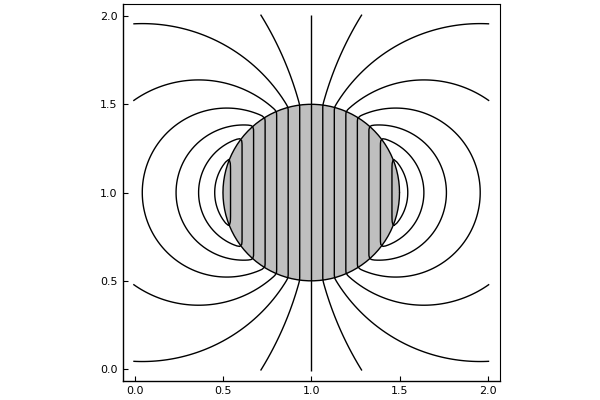

In [20]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=31))
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

Plot the result in a frame in which cylinder is stationary

In [24]:
ψtot = Nodes(Dual,ψ)
ψtot .= ψ .+ xg .- xc;

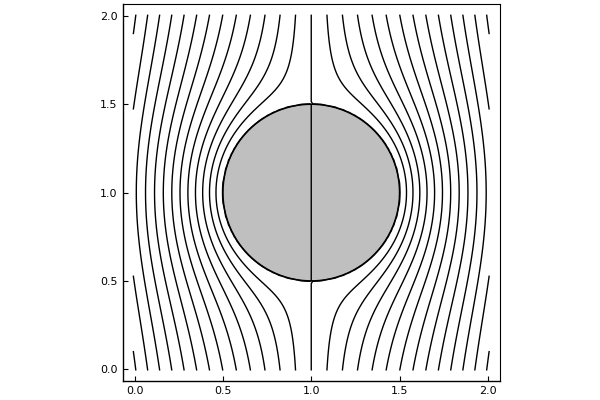

In [26]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψtot,linecolor=:black,levels=range(-1,1,length=31))
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

Compare the generated vortex sheet `f/ds` with the exact solution

In [33]:
fex = -2*cos.(θ[1:n]);
errinf = LinearAlgebra.norm(f./ds-fex,Inf)

0.04160331209142765

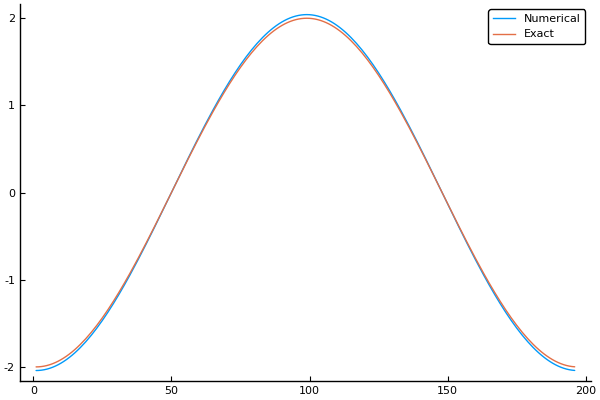

In [35]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

#### Now try storing the Schur matrix

In [36]:
L⁻¹(w::T) where {T} = L\w
PSstore = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true,store=true)

Saddle system with 196 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{196}


This way is significantly faster

  0.002975 seconds (41 allocations: 651.547 KiB)


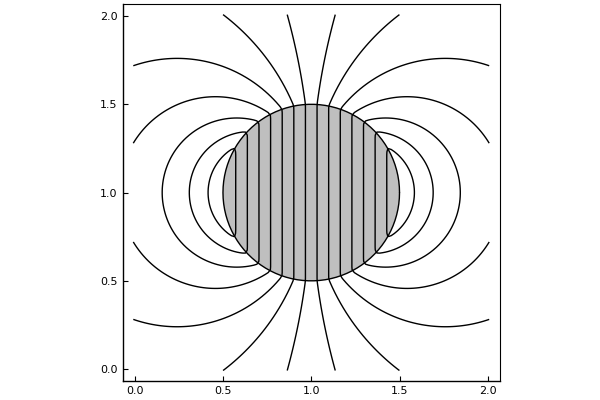

In [38]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n] .- xc);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = PSstore\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

But there is significantly more noise in the force

In [39]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f./ds-fex,Inf)

0.22855215027259246

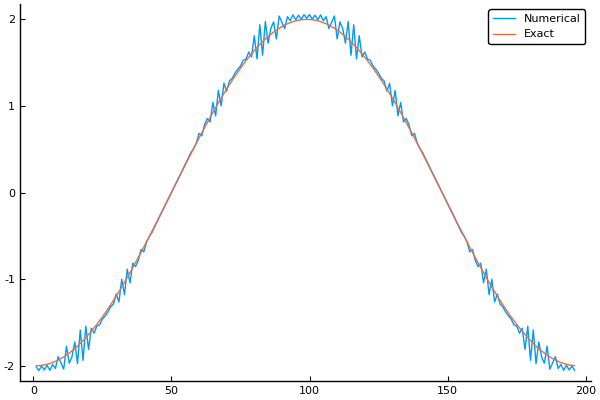

In [40]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

So let's filter it

In [41]:
Ẽ = Regularize(X,dx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(Ẽ,f,w);
Ẽmat = InterpolationMatrix(Ẽ,w,f);

In [45]:
f̃ = ScalarData(X);

In [46]:
P(f) = Ẽmat*(H̃mat*f)
PScond = SaddleSystem((w,f̃),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true,conditioner=P,store=true)

Saddle system with 196 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{196}


  0.002272 seconds (46 allocations: 779.672 KiB)


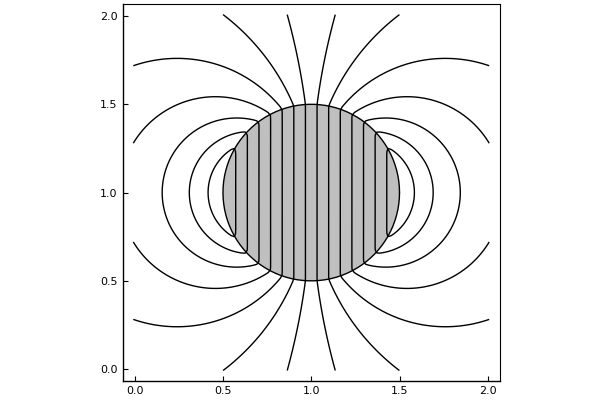

In [47]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n] .- 1);
ψ = Nodes(Dual,w);
@time ψ,f̃ = PScond\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [48]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f̃./ds-fex,Inf)

0.052911768219712885

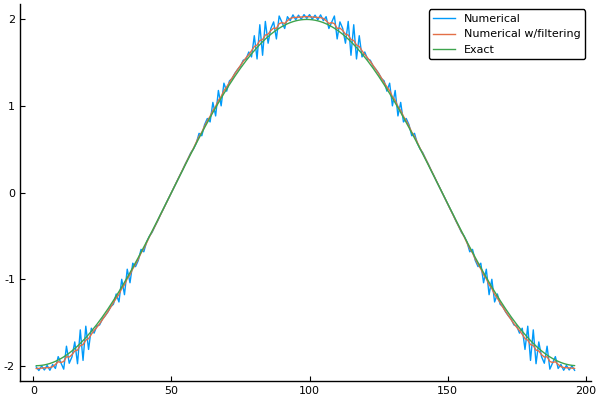

In [49]:
plot(f./ds,label="Numerical")
plot!(f̃./ds,label="Numerical w/filtering")
plot!(fex,label="Exact")

### Now flow about a cylinder with net circulation

#### Set up some helpful operators

`oB` is the basis vector for uniform Lagrange point data. As a transpose, it is a summation operator on Lagrange point data.

In [50]:
oB = zeros(size(f))
oB .= 1;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

In [51]:
S = Matrix(PS.S);

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [52]:
S₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/S₀;

#### Now set the problem parameters

In [53]:
# The desired streamfunction on the circle surface
ψb .= 1

# The desired circulation about the circle
Γ0 = 1;

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [54]:
f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);

#### Check that this `f` gives correct circulation

In [55]:
sum(f)

0.9999999999999996

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [56]:
ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))

1.5507044895456807

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [57]:
ψ .= -(L\(Hmat*f)) .+ ψ₀;

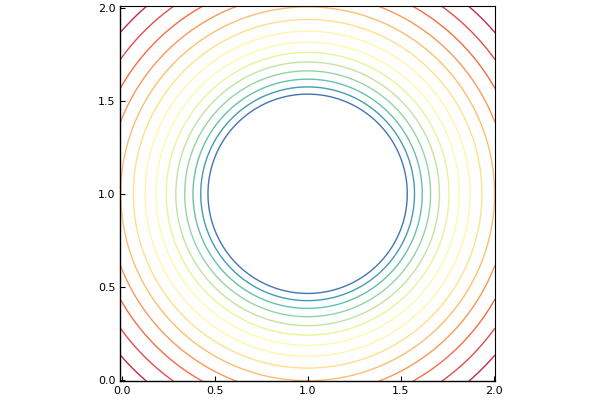

In [58]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)

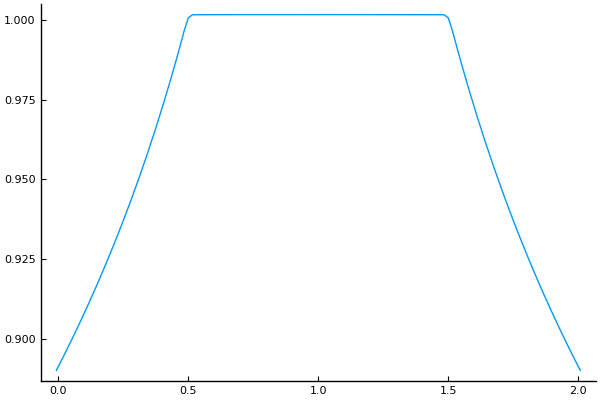

In [59]:
jcent = ny ÷ 2
plot(xg,ψ[:,jcent],legend=:false)

### Now flow about another shape with net circulation

In [60]:
n = 252;
R = 0.5;
xc = 1.0
yc = 1.0
nquart = n÷4
xb = zeros(n+1)
yb = zeros(n+1)
for i in 1:nquart
    xb[i] = xc + R
    yb[i] = yc - R + 2R*(i-1)/nquart
    xb[nquart+i] = xc + R - 2R*(i-1)/nquart
    yb[nquart+i] = yc + R
    xb[2nquart+i] = xc - R
    yb[2nquart+i] = yc + R - 2R*(i-1)/nquart
    xb[3nquart+i] = xc - R + 2R*(i-1)/nquart
    yb[3nquart+i] = yc - R
end
xb[n+1] = xb[1]
yb[n+1] = yb[1]
ds = 2R/nquart;
X = VectorData(xb[1:n],yb[1:n]);
f = ScalarData(X);

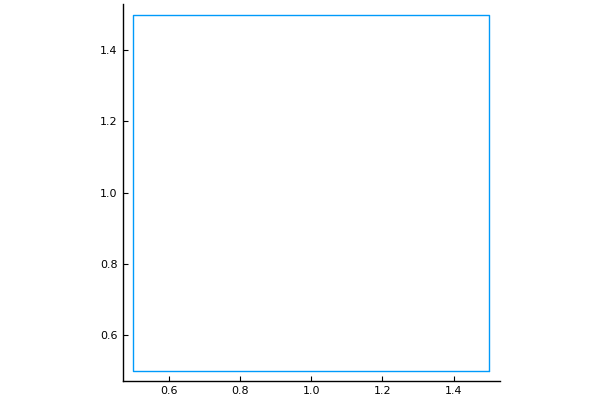

In [61]:
plot(xb,yb,ratio=1,legend=:false)

In [62]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 1.0


In [63]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

#### And now create the saddle-point system

In [64]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 252 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{252}


#### Create some data structures for general use

In [65]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψ = Nodes(Dual,w)
f = ScalarData(X);

In [66]:
oB = zeros(size(f))
oB .= 1;

`S` is a matrix form of the Schur complement,

$$S = -EL^{-1}H$$

In [67]:
S = Matrix(PS.S);

`T` is a modified version of the Schur complement. Note that the operator

$$S^{-1}T S^{-1} = S^{-1}\left(S - \frac{o_B^T o_B}{o_B^T S^{-1} o_B} \right) S^{-1}$$

is identically zero when it acts upon uniform Lagrange point data. It produces the influence of the variable part of Lagrange point data on the vortex sheet strength.

In [68]:
S₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/S₀;

#### Now set the problem parameters

In [69]:
# The desired streamfunction on the circle surface
ψb .= 1

# The desired circulation about the circle
Γ0 = 1;

#### Compute the vortex sheet strength

As mentioned above, the first term is actually zero when $\psi_b$ is uniform. So this sheet strength is entirely due to the desired circulation, distributed uniformly on the surface.

In [70]:
f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);

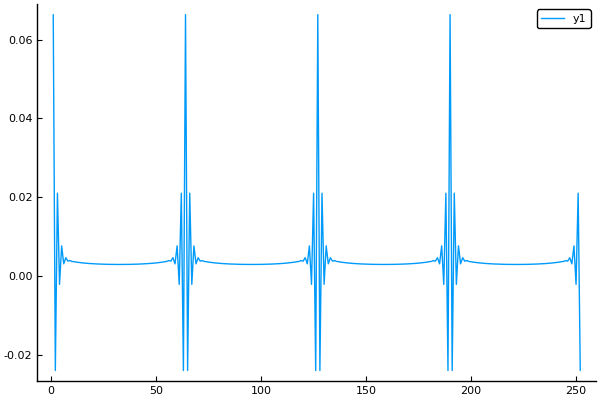

In [73]:
plot(f)

#### Check that this `f` gives correct circulation

In [74]:
sum(f)

1.0000000000000002

#### Now the streamfunction

Here, we compute the uniform streamfunction. We first cancel the circulation due to the vortex sheet (attributable to the desired circulation), and then we add the desired streamfunction on the circle.

In [75]:
ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))

1.5775613969647342

The overall streamfunction is due to the field induced by the vortex sheet and to the uniform value. 

In [76]:
ψ .= -(L\(Hmat*f)) .+ ψ₀;

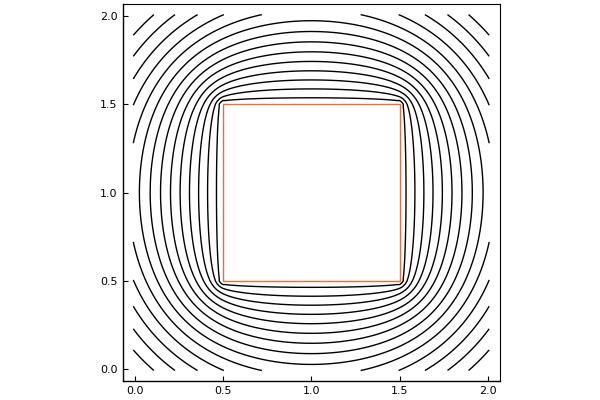

In [77]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black)
plot!(xb,yb)

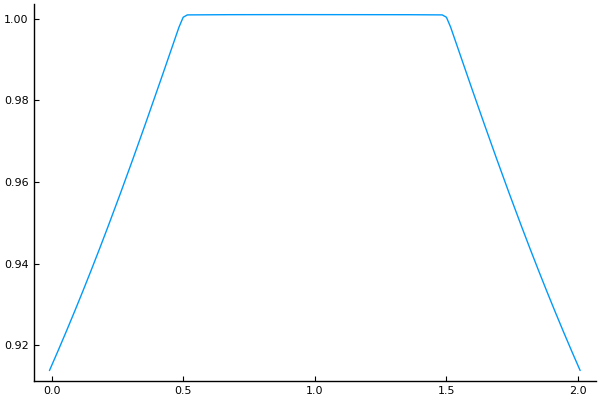

In [78]:
jcent = ny ÷ 2
plot(xg,ψ[:,jcent],legend=:false)

### Extra stuff

In [84]:
function laplacian_symm!(out::Nodes{Dual,NX, NY}, w::Nodes{Dual,NX, NY}) where {NX, NY}
    @inbounds for y in 2:NY-1, x in 2:NX-1
        out[x,y] = w[x,y-1] + w[x-1,y] - 4w[x,y] + w[x+1,y] + w[x,y+1]
    end
    @inbounds for y in 2:NY-1
        out[1,y]  = w[1,y-1]            - 4w[1,y] + w[2,y] + w[1,y+1]
        out[NX,y] = w[NX,y-1] + w[NX-1,y]- 4w[NX,y]        + w[NX,y+1]
    end
    @inbounds for x in 2:NX-1
        out[x,1]  = w[x-1,1] + w[x+1,1] - 4w[x,1] + w[x,2]
        out[x,NY] = w[x-1,NY]+ w[x+1,NY]- 4w[x,NY] + w[x,NY-1]
    end
    out[1,1] = -4w[1,1] + w[1,2] + w[2,1]
    out[NX,1] = -4w[NX,1] + w[NX-1,1] + w[NX,2]
    out[1,NY] = -4w[1,NY] + w[1,NY-1] + w[2,NY]
    out[NX,NY] = -4w[NX,NY] + w[NX,NY-1] + w[NX-1,NY]
    out
end

laplacian_symm! (generic function with 1 method)